https://www.kaggle.com/datasets/awsaf49/vit-keras-fixed-dataset

In [1]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
!pip install vit_keras
!pip install -U tensorflow-addons
from vit_keras import vit
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


TF version: 2.12.0
Hub version: 0.13.0
GPU is available


In [2]:
!pip install tensorflow_hub

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import functools

(train_ds, valid_ds), info = tfds.load("oxford_flowers102", split=["test", "validation"], as_supervised=True, with_info=True)
int_to_class_label = info.features['label'].int2str
num_classes = 102
image_size = 112
IMG_WIDTH = IMG_HEIGHT = image_size
input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)

CLASSES_TO_CONSIDER = list(range(num_classes)) 


def preprocess_image(image, label, height, width):
    image = tf.image.resize(image, [height,width])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def filter_by_classes(img, label):
    bools = tf.equal(label, CLASSES_TO_CONSIDER)
    return tf.reduce_any(bools)    


partial_preprocess_image = functools.partial(preprocess_image, height=IMG_HEIGHT, width=IMG_WIDTH)
train_ds = train_ds.filter(filter_by_classes).map(partial_preprocess_image).cache().shuffle(buffer_size=1000)
valid_ds = valid_ds.filter(filter_by_classes).map(partial_preprocess_image).cache().shuffle(buffer_size=1000)
     
def get_x_y_from_ds(ds):
    x, y = [], []
    for img, label in ds.cache().as_numpy_iterator():
        x.append(img)
        y.append(label)

    return np.array(x), np.array(y)

x_train, y_train = get_x_y_from_ds(train_ds)
x_test, y_test = get_x_y_from_ds(valid_ds)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
# print("Building model with", MODULE_HANDLE)
vit_model = vit.vit_b16(
        image_size = image_size,
        activation = 'gelu',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 102)

model = tf.keras.Sequential([
    vit_model,
    tf.keras.layers.Flatten(name="flatten"),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(1072, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(102)
])

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 7, 7
  warnings.warn(


In [21]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=.5e-3), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [24]:
batch_size = 128
epochs = 10

In [25]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint_filepath = "/tmp/checkpoint"
checkpoint_callback = ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)

earlystopping = EarlyStopping(monitor='val_loss', patience=5)

hist = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs, 
    validation_data = (x_test, y_test),
    callbacks=[checkpoint_callback],
    verbose=1)

Epoch 1/10
49/49 [==============================] - 73s 1s/step - loss: 0.1263 - accuracy: 0.9616 - val_loss: 0.6030 - val_accuracy: 0.8637
Epoch 2/10
49/49 [==============================] - 61s 1s/step - loss: 0.1032 - accuracy: 0.9702 - val_loss: 0.6967 - val_accuracy: 0.8549
Epoch 3/10
49/49 [==============================] - 62s 1s/step - loss: 0.1171 - accuracy: 0.9675 - val_loss: 1.1412 - val_accuracy: 0.7716
Epoch 4/10
49/49 [==============================] - 62s 1s/step - loss: 0.3884 - accuracy: 0.8984 - val_loss: 1.0612 - val_accuracy: 0.7824
Epoch 5/10
49/49 [==============================] - 62s 1s/step - loss: 0.2604 - accuracy: 0.9286 - val_loss: 1.0913 - val_accuracy: 0.7637
Epoch 6/10
49/49 [==============================] - 62s 1s/step - loss: 0.2092 - accuracy: 0.9441 - val_loss: 0.7010 - val_accuracy: 0.8461
Epoch 7/10
49/49 [==============================] - 62s 1s/step - loss: 0.1682 - accuracy: 0.9520 - val_loss: 1.3984 - val_accuracy: 0.7520
Epoch 8/10
49/49 [==

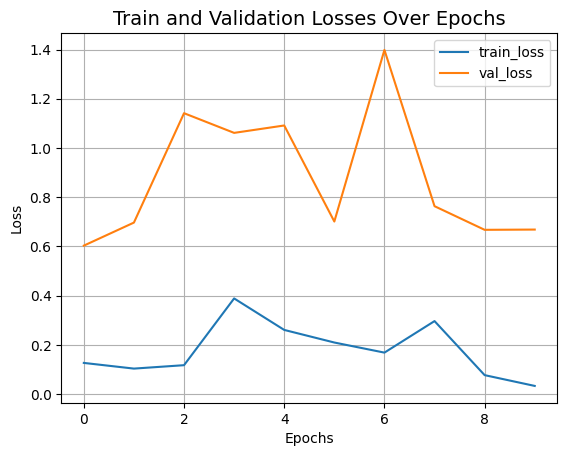

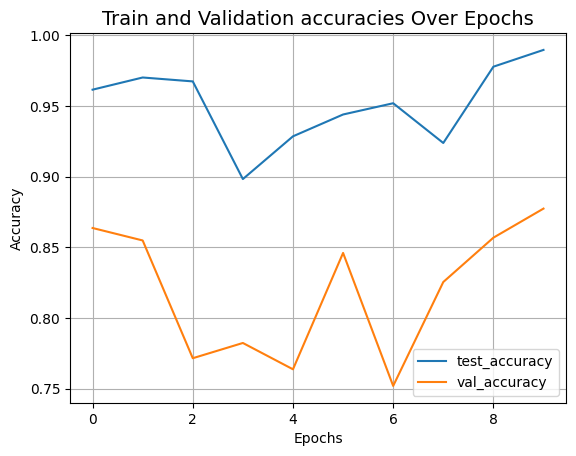

In [26]:
plt.plot(hist.history["loss"], label="train_loss")
plt.plot(hist.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

plt.plot(hist.history["accuracy"], label="test_accuracy")
plt.plot(hist.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation accuracies Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [31]:
y_pred = model.predict(x_test)
predicted_ids = np.argmax(y_pred, axis=-1)
true_classes = np.argmax(y_test, axis=-1)
accuracy = np.mean(predicted_ids == true_classes)
print('Precisão:', accuracy)

32/32 [==============================] - 3s 106ms/step
Precisão: 0.8774509803921569


In [32]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report

# Calcular a precisão, recall e F1-score para cada classe
report = classification_report(true_classes, predicted_ids, target_names=np.array(info.features['label'].names))

# Exibir o relatório de classificação
print(report)

                           precision    recall  f1-score   support

            pink primrose       0.82      0.90      0.86        10
hard-leaved pocket orchid       0.91      1.00      0.95        10
         canterbury bells       1.00      0.10      0.18        10
                sweet pea       0.75      0.30      0.43        10
         english marigold       1.00      1.00      1.00        10
               tiger lily       0.82      0.90      0.86        10
              moon orchid       1.00      0.50      0.67        10
         bird of paradise       1.00      1.00      1.00        10
                monkshood       0.83      1.00      0.91        10
            globe thistle       1.00      1.00      1.00        10
               snapdragon       1.00      0.80      0.89        10
              colt's foot       1.00      1.00      1.00        10
              king protea       0.91      1.00      0.95        10
            spear thistle       1.00      1.00      1.00     

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85685760  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense_3 (Dense)             (None, 4096)              3149824   
                                                                 
 dense_4 (Dense)             (None, 1072)              4391984   
                                                                 
 dropout_1 (Dropout)         (None, 1072)              0         
                                                                 
 dense_5 (Dense)             (None, 102)               109446    
                                                                 
Total params: 93,337,014
Trainable params: 93,337,014
